In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc

pd.set_option("display.max.columns", None)

In [9]:
data = pd.read_table('data/XYZCorp_LendingData.txt')
data.to_csv('data/XYZCorp_LendingData.csv', index = False)

C:\Users\Caio\AppData\Local\Temp\ipykernel_10544\3180723633.py:1: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table('data/XYZCorp_LendingData.txt')


In [2]:
data = pd.read_csv('data/XYZCorp_LendingData.csv', parse_dates = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d'])

data = data[data['application_type'] == 'INDIVIDUAL'].reset_index(drop = True).copy()
data['days_w_cr'] = (data['issue_d'] - data['earliest_cr_line']).dt.days

for col in ['mths_since_last_delinq', 'mths_since_last_major_derog']:
    data[col + '_flag'] = data[col].notna().astype(int)
    data[col].fillna(-1, inplace = True)

data['emp_length'].fillna('Unknown', inplace = True)
data['delinq_2yrs'] = data['delinq_2yrs'].astype(int)
data['mths_since_last_record'].fillna(-1, inplace = True)

model_attributes = ['emp_length', 'home_ownership', 'annual_inc',
                    'verification_status', 'zip_code', 'addr_state', 'dti',
                    'delinq_2yrs', 'days_w_cr', 'inq_last_6mths',
                    'mths_since_last_record', 'pub_rec','open_acc',
                    'total_acc', 'purpose', 'mths_since_last_delinq',
                    'mths_since_last_major_derog', 'mths_since_last_delinq_flag', 'mths_since_last_major_derog_flag']

target_attributes = ['default_ind', 'recoveries']

application_attributes = ['desc', 'purpose', 'title']

inst_attributes = ['total_bal_il', 'il_util']
rev_attributes = ['revol_bal', 'revol_util', 'total_rev_hi_limv', 'max_bal_bc']
account_attributes =  ['tot_cur_bal', 'all_util', 'acc_now_delinq']

acc_activity = ['open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
                'mths_since_rcnt_il', 'open_rv_12m', 'open_rv_24m', 'total_cu_tl']
collections = ['collections_12_mths_ex_med', 'tot_coll_amt']

loan_attributes = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
                   'int_rate', 'installment', 'grade', 'sub_grade', 'issue_d',
                   'pymnt_plan', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
                   'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
                   'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                   'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
                   'last_credit_pull_d', 'policy_code']

non_train_attributes = ['inq_fi', 'inq_last_12m', 'dti_joint', 'annual_inc_joint', 'verified_status_joint'] #attributes only not NaN in test data

C:\Users\Caio\AppData\Local\Temp\ipykernel_4276\2348233518.py:1: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/XYZCorp_LendingData.csv', parse_dates = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d'])


In [3]:
encoding_cols = ['emp_length', 'home_ownership', 'verification_status', 'zip_code', 'addr_state', 'purpose']

encoder = OneHotEncoder()
encoded_data = pd.DataFrame(encoder.fit_transform(data[encoding_cols]).toarray())

test = data[model_attributes + ['default_ind', 'issue_d']].drop(encoding_cols, axis = 1).join(encoded_data)
test.columns = test.columns.map(str)


In [4]:
#test train split

train_data = test[test['issue_d'] < dt.datetime(2015,6,1)].copy()
test_data = test[test['issue_d'] >= dt.datetime(2015,6,1)].copy()


In [5]:
def model_train(encoded_data, save = False):
    
    model = RandomForestClassifier()
    
    model.fit(encoded_data.drop(['default_ind', 'issue_d'], axis = 1), encoded_data['default_ind'])
    return model

model = model_train(train_data)

In [10]:
train_data['default_ind'].value_counts()


0    552822
1     46156
Name: default_ind, dtype: int64

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256238
           1       0.00      0.00      0.00       311

    accuracy                           1.00    256549
   macro avg       0.50      0.50      0.50    256549
weighted avg       1.00      1.00      1.00    256549

no defaults: roc auc = 0.500
model prediction: roc auc = 0.610


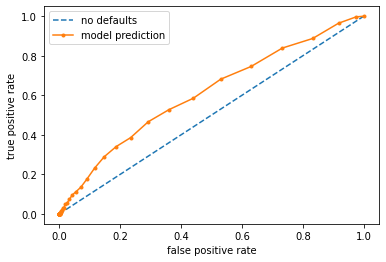

In [26]:
def model_eval(test_data, model):
    
    y_test = test_data['default_ind']
    X_test = test_data.drop(['default_ind', 'issue_d'], axis = 1)

#-----------------predictions-----------------------    
    prob_default = model.predict_proba(X_test)[:,1]
#-------------------metrics-------------------------    
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))

    false_auc = roc_auc_score(y_test, y_test.clip(upper = False))
    model_auc = roc_auc_score(y_test, prob_default)
    
    print('no defaults: roc auc = %.3f' % (false_auc))
    print('model prediction: roc auc = %.3f' % (model_auc))
    
    false_fpr, false_tpr, _ = roc_curve(y_test, y_test.clip(upper = False))
    model_fpr, model_tpr, _ = roc_curve(y_test, prob_default)

    plt.plot(false_fpr, false_tpr, linestyle = '--', label = 'no defaults')
    plt.plot(model_fpr, model_tpr, marker = '.', label = 'model prediction')

    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()

    res = test_data.copy()

    res['y_pred'] = y_pred

    return res['y_pred']

y_pred = model_eval(test_data, model)

In [27]:
y_pred.value_counts()

0    256547
1         2
Name: y_pred, dtype: int64